## Click Rate Modelling
_Hand in date: 2018-04-30_

|** Name** | **Student id** | **E-mail** |
|:- |:-|:-|
| Claudia Miulescu | 11434805 |  miulescu.claudia@gmail.com|
| Viswanathan Saravanan | 11417846 | viswanathan@live.in |
| Varesh Tapadia | 11434678 | varesh.tapadia@gmail.com |
| Bas den Heijer | 11434791 | bas.denheijer@ortec.com |

## Setup
Some configuration. We expect the train.gz from https://www.kaggle.com/c/avazu-ctr-prediction/data (1.117.527.809 bytes). No need to extract it, but it also works if the file is already extracted.

In [1]:
# Input
input_file = 'train.gz'
total_rows_in_file = 40428967 # Used for progress indication (None for unknown)

ultimate_answer = 42
seed = ultimate_answer # Used in train/test split.

records_per_chunk = 1e5
subset = 5*records_per_chunk # Run everything on a smaller subset of the file (for debugging), None for whole file.
subset = int(0.01*total_rows_in_file)
subset = None
sampled_df_frac = 0.01 # The sample fraction we use to do feature selection and grid search (should fit in memory)

print_processing_time = True
test_frac = 0.25 # Part of data to use for verification.

dropped_columns = ['id', 'device_id', 'device_ip', 'site_id', 'site_domain', 'app_id', 'device_model', 'C14']

The imports:

In [2]:
import random
import sys
import time
import gzip
import csv
import datetime
import os.path

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, mean_squared_error

from IPython.display import clear_output

Version numbers for reference. Our machine has:

```
The Python version is 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
The pandas version is 0.22.0
The numpy version is 1.14.0
The scikit-learn version is 0.19.1
```

Especially the scikit-learn version is important if you're going to use the .pkl-files!

In [3]:
print('The Python version is ' + sys.version)
print('The pandas version is ' + pd.__version__)
print('The numpy version is ' + np.__version__)
print('The scikit-learn version is ' + sklearn.__version__)

The Python version is 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
The pandas version is 0.22.0
The numpy version is 1.14.0
The scikit-learn version is 0.19.1


### Result loader
As some operations take a lot of time, try to load them from disk first:

In [4]:
# Internal files
column_values_file = 'column_values.pkl'
naive_bayes_grid_file = 'naive_bayes_grid.pkl'
naive_bayes_file = 'naive_bayes.pkl'
logistic_regression_grid_file = 'logistic_regression_grid.pkl' 
logistic_regression_file = 'logistic_regression.pkl'

In [5]:
def try_load(filename, func_otherwise, force=False):
    if force or not os.path.isfile(filename):
        result = func_otherwise()
        print("Saving to %s" % filename)
        joblib.dump(result, filename)
        return result
    else:
        print("Loading from %s" % filename)
        return joblib.load(filename)

## Reading in the data
Set up some convenient functions to read in the data in bits, so we never have to keep all of it in memory. Otherwise this feeble laptop catches fire.

Make a nice generator we can use to iterate over the complete file in parts. You can select the training or test set, or get both. (It will read the complete file from disk every time, but only return a subset of the data.)

We use a random sample of the complete data as the test data.

In [6]:
def chunked_file(flavor):
    """flavor is one of ['train', 'test', 'all']."""
    assert flavor in ['train', 'test', 'all']
    
    rnd = random.Random(seed)
    
    start_time = time.time()
    
    global total_rows_in_file
    observed_rows = 0
    expected_rows = subset
    if expected_rows == None:
        expected_rows = total_rows_in_file
    
    if print_processing_time: 
        print('Processing file: ...')
    
    for chunk in pd.read_csv(input_file, chunksize=records_per_chunk, nrows=subset):
        my_seed = rnd.randint(0, 2**32-1) # Seed for a numpy.random.RandomState
        observed_rows += chunk.shape[0]
        
        if flavor == 'all':
            yield chunk
        else:
            train, test = train_test_split(chunk, test_size=test_frac, random_state=my_seed)
            yield {'train': train, 'test': test}[flavor]
        
        if total_rows_in_file != None:
            pct_done = observed_rows / expected_rows * 100
            eta = datetime.timedelta(seconds=(time.time() - start_time) / observed_rows * (expected_rows - observed_rows))
            if print_processing_time: 
                clear_output(wait=True)
                print('Processing file: %.2f%% (eta: %s)' % (pct_done, str(eta)))
    
    total_rows_in_file = observed_rows
    if print_processing_time: 
        clear_output(wait=True)
        print('Processing file: Done, took %s.' % str(datetime.timedelta(seconds=(time.time() - start_time))))

### Reading in a sample in memory
For some parts of the code we need to see the whole dataset in memory, which unfortunately doesn't fit. Here is a function that reads through the whole file, but only concatenates a subset into one DataFrame. We use this for feature and parameter selection.

In [7]:
def sampled_file(frac=.01, flavor='train'):
    """Get a part of the data, but all in memory."""
    df = pd.DataFrame()
    rnd = random.Random(seed+1)
    
    return pd.concat((chunk.sample(frac=frac, random_state=rnd.randint(0, 2**32-1)) for chunk in chunked_file(flavor)),
                     ignore_index=True)

In [8]:
sampled_df = sampled_file(frac=sampled_df_frac)

Processing file: Done, took 0:03:08.926696.


## Data Preparation

### Find out all categories
All our columns will be categories. To use these with the scikit-learn algorithms, they will be converted to binary variables. Each possible value will get their own column, so, effectively, we need to know all possible values for each column before starting.

Unique values in the data:

| Column | Unique values in the data |
|---|---|
| id | 40428967 |
| click | 2 |
| hour | 240 |
| C1 | 7 |
| banner_pos | 7 |
| site_id | 4737 |
| site_domain | 7745 |
| site_category | 26 |
| app_id | 8552 |
| app_domain | 559 |
| app_category | 36 |
| device_id | 2686408 |
| device_ip | 6729486 |
| device_model | 8251 |
| device_type | 5 |
| device_conn_type | 4 |
| C14 | 2626 |
| C15 | 8 |
| C16 | 9 |
| C17 | 435 |
| C18 | 4 |
| C19 | 68 |
| C20 | 172 |
| C21 | 60 |

Later, we will convert `hour` in 2 new columns with `day_of_week` and `time`.

In [9]:
def get_column_values(gz_file):
    columns = None
    column_values = None
    
    for chunk in chunked_file('all'):
        if columns == None:
            columns = set(chunk.columns) - set(dropped_columns + ['hour'])
            column_values = {col: set() for col in columns}
        for col in columns:
            column_values[col] = column_values[col].union(chunk[col])
    
    column_values['day_of_week'] = list(range(0,7))
    column_values['time'] = list(range(0,24))
    
    return column_values

In [10]:
column_values = try_load(column_values_file, lambda: get_column_values(input_file))

Processing file: Done, took 0:03:11.333163.
Saving to column_values.pkl


### Clean up data

In [11]:
def prepare_data(df):
    df = clean_data(df)
    df = dummify_data(df)
    df = remove_irrelevant_columns(df)
    return extract_data(df)

In [12]:
def clean_data(df):
    df = df.dropna(how='any')

    #Drop the 'id', 'device_id', 'device_ip' columns
    df = df.drop(dropped_columns, axis=1)
    
    #Convert 'hour' field into datetime type
    df['hour'] = df['hour'].astype(str)
    df['hour'] = df['hour'].apply(lambda x: datetime.datetime.strptime(x,'%y%m%d%H'))

    #Extract 'day of week' and 'hour of day' as separate columns
    df['day_of_week'] = df['hour'].dt.dayofweek
    df['time'] = df['hour'].dt.hour

    #Drop the hour column
    df = df.drop('hour', axis=1)
    
    return df

In [13]:
def dummify_data(df):
    # Create dummies for every ordinal variables (or group of ordinal var) to distinguish between
    # the effects of each different values.
    columns = set(df.columns) - set(['click'])
    
    for col in columns:
        df[col] = pd.Categorical(df[col], categories=column_values[col])

    df = pd.get_dummies(df, columns=columns)

    return df

In [14]:
def extract_data(df):
    #Extract Y
    y = df['click']
    #Extract X
    X = df.drop(['click'], axis=1)
    return X, y

## Feature Selection
We use an online feature selection model to extract the most important variables from the training dataset. The goal is to reduce the amount of time spent in fitting the classification models. 

In [15]:
#Use partial training data for the feature selection model
def get_irrelevant_columns_from_model():
    df = clean_data(sampled_df)
    df = dummify_data(df)
    X, y = extract_data(df)
 
    time_fit = -time.time()
    clf = PassiveAggressiveClassifier(C = 0.01, random_state = seed).fit(X, y)
    time_fit += time.time()

    irr_col = []
    #Build the list of irrelevant columns based on the online classifier  
    column_names = df.drop(['click'], axis=1).columns
    for coef, name in zip(clf.coef_[0], column_names):
        if coef == 0:
            irr_col.append(name)

    print("Irrelevant features according to PA model: %d / %d" % (len(irr_col), len(column_names)))
    print('Time taken: %s' % str(datetime.timedelta(seconds=time_fit)))
    return irr_col

In [16]:
irrelevant_columns = get_irrelevant_columns_from_model()

C:\Simpel\Anaconda2\envs\Python3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Irrelevant features according to PA model: 511 / 1431
Time taken: 0:00:14.773644


In [17]:
def remove_irrelevant_columns(df):    
    df = df.drop(irrelevant_columns, axis=1)
    return df

## Naive Bayes

### Parameter search
The sklearn Naive Bayes class (BernoulliNB: http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) has a parameter `alpha` that determines the "Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing)."

We try a 'grid' search on the parameter on the smaller sample data (so it doesn't take forever).

In [18]:
X_sample, y_sample = prepare_data(sampled_df)

In [19]:
# This block is mostly copied from Bas' Machine Learning assignment
def try_model(model, param_grid, X, y):
    grid = GridSearchCV(model, param_grid, return_train_score=True, cv=5, scoring='neg_log_loss', verbose=10, n_jobs=3)
    grid.fit(X, y)
    
    model_name = type(model).__name__
    print('%s (params=%s): %f' % (model_name, grid.best_params_, grid.best_score_))
    if len(param_grid) == 1:
        plot_validation(grid, 'Validation Curve: %s' % model_name)
    
    return grid

def plot_validation(grid_results, title):
    # Inspired by http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
    train_scores_mean = grid_results.cv_results_['mean_train_score']
    train_scores_std = grid_results.cv_results_['std_train_score']
    test_scores_mean = grid_results.cv_results_['mean_test_score']
    test_scores_std = grid_results.cv_results_['std_test_score']

    param, = grid_results.best_params_.keys()
    param_values = [v[param] for v in grid_results.cv_results_['params']]
    
    plt.title(title)
    plt.xlabel(param)
    plt.ylabel('Score')

    if param_values[-1] / param_values[0] > 1e4:
        plt.xscale('log')
    plt.plot(param_values, train_scores_mean, label='Training score', color='tab:orange')
    plt.fill_between(param_values, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                     alpha=0.2, color='tab:orange')
    plt.plot(param_values, test_scores_mean, label='Cross-validation score', color='tab:blue')
    plt.fill_between(param_values, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                     alpha=0.2, color='tab:blue')
    plt.legend(loc='best')
    plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   29.5s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  4.8min finished


BernoulliNB (params={'alpha': 100.0}): -0.758653


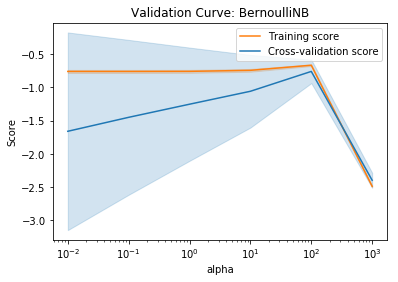

Saving to naive_bayes_grid.pkl


In [20]:
naive_bayes_grid = try_load(naive_bayes_grid_file,
                            lambda: try_model(BernoulliNB(), {'alpha': np.logspace(-2, 3, 6)}, X_sample, y_sample))

In [21]:
print('Best alpha: %f (= 10^%f)' % (naive_bayes_grid.best_params_['alpha'], np.log10(naive_bayes_grid.best_params_['alpha'])))
print(' gives score: %f' % naive_bayes_grid.best_score_)

Best alpha: 100.000000 (= 10^2.000000)
 gives score: -0.758653


### Training the model

In [22]:
def train_model(model):
    time_total = 0
    time_prepare = 0
    time_fit = 0

    time_total -= time.time()

    for chunk in chunked_file('train'):
        time_prepare -= time.time()
        X, y = prepare_data(chunk)
        time_prepare += time.time()

        time_fit -= time.time()
        model.partial_fit(X, y, classes=[0,1])
        time_fit += time.time()

    time_total += time.time()

    print('Total time: %ss' % time_total)
    print(' Reading time: %ss' % (time_total - time_prepare - time_fit))
    print(' Prepare time: %ss' % time_prepare)
    print(' Fit time: %ss' % time_fit)
    
    return model

Do the Naive Bayes training, but try to load it from disk first as that will take a lot of time!

In [23]:
naive_bayes = try_load(naive_bayes_file,
                       lambda: train_model(BernoulliNB(alpha=naive_bayes_grid.best_params_['alpha'])))

Processing file: Done, took 0:41:05.377819.
Total time: 2465.3778188228607s
 Reading time: 191.08253526687622s
 Prepare time: 945.0594277381897s
 Fit time: 1329.2358558177948s
Saving to naive_bayes.pkl


### Scoring the test subset
With the fitting model, we can score the test set.

In [24]:
def score_model(model):
    time_total = 0
    time_prepare = 0
    time_predict = 0
    time_score = 0
    
    log_loss_sum = 0
    sse_sum = 0
    records = 0
    
    time_total -= time.time()
    
    for chunk in chunked_file('test'):
        time_prepare -= time.time()
        X, y = prepare_data(chunk)
        time_prepare += time.time()

        time_predict -= time.time()
        y_hat = model.predict_proba(X)[:,1]
        time_predict += time.time()

        time_score -= time.time()
        log_loss_sum += log_loss(y, y_hat, normalize=False)
        sse_sum += np.sum((y - y_hat) ** 2)
        records += len(y)
        time_score += time.time()
        
    time_total += time.time()

    print('Sample size: %d' % records)
    print('Log loss: %f' % log_loss_sum)
    print('SSE: %f' % sse_sum)
    print('Average Log loss: %f' % (log_loss_sum / records))
    print('MSE: %f' % (sse_sum / records))
    
    print()
    
    print('Total time: %ss' % time_total)
    print(' Reading time: %ss' % (time_total - time_prepare - time_predict - time_score))
    print(' Prepare time: %ss' % time_prepare)
    print(' Predict time: %ss' % time_predict)
    print(' Scoring time: %ss' % time_score)

In [25]:
score_model(naive_bayes)

Processing file: Done, took 0:13:16.806606.
Sample size: 10107242
Log loss: 7705169.631059
SSE: 1996610.849564
Average Log loss: 0.762341
MSE: 0.197543

Total time: 796.8076055049896s
 Reading time: 182.19911551475525s
 Prepare time: 287.35280537605286s
 Predict time: 324.41832852363586s
 Scoring time: 2.8373560905456543s


## Logistic Regression

### Model Parameter Selection

For selecting the model parameters, we ran various models against the training data set and based on the F1 score, picked up the best model

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   39.3s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   54.6s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:  3.0min finished
C:\Simpel\Anaconda2\envs\Python3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureW

SGDClassifier (params={'alpha': 0.01}): -0.432576


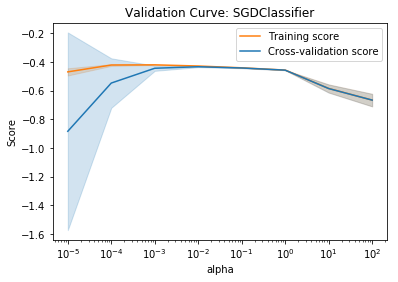

Saving to logistic_regression_grid.pkl


In [26]:
logistic_regression_grid = try_load(logistic_regression_grid_file,
                            lambda: try_model(SGDClassifier(loss='log'), {'alpha': np.logspace(-5, 2, 8)}, X_sample, y_sample))

### Training the Model

In [27]:
logistic_regression = try_load(logistic_regression_file,
                       lambda: train_model(SGDClassifier(alpha=logistic_regression_grid.best_params_['alpha'], loss='log')))

Processing file: Done, took 0:25:44.845334.
Total time: 1544.8453342914581s
 Reading time: 184.12029933929443s
 Prepare time: 945.797798871994s
 Fit time: 414.9272360801697s
Saving to logistic_regression.pkl


In [28]:
score_model(logistic_regression)

Processing file: Done, took 0:08:35.158113.
Sample size: 10107242
Log loss: 4337170.550466
SSE: 1347397.564076
Average Log loss: 0.429115
MSE: 0.133310

Total time: 515.1596143245697s
 Reading time: 184.3999080657959s
 Prepare time: 288.6251595020294s
 Predict time: 39.38824701309204s
 Scoring time: 2.7462997436523438s
